In [1]:
import random

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

from module.utils import set_random_seed
from module.dataset.digit import DigitDataset
from module.da.dann import DANN
from module.dsn.dsn import DSN

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

%matplotlib inline

In [2]:
# source_datapath = '/tmp2/itsmystyle/hw3_data/digits/svhn/test.csv'
# source_imagedir = '/tmp2/itsmystyle/hw3_data/digits/svhn/test/'
# target_datapath = '/tmp2/itsmystyle/hw3_data/digits/mnistm/test.csv'
# target_imagedir = '/tmp2/itsmystyle/hw3_data/digits/mnistm/test/'

target_datapath = '/tmp2/itsmystyle/hw3_data/digits/svhn/test.csv'
target_imagedir = '/tmp2/itsmystyle/hw3_data/digits/svhn/test/'
source_datapath = '/tmp2/itsmystyle/hw3_data/digits/mnistm/test.csv'
source_imagedir = '/tmp2/itsmystyle/hw3_data/digits/mnistm/test/'

# model_path = 'models/dann_s2m/model_best_0.68830.pth.tar'
model_path = 'models/dann_m2s/model_best.pth.tar'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_random_seed(42)
source_dataset = DigitDataset(source_datapath, source_imagedir)
target_dataset = DigitDataset(target_datapath, target_imagedir)

# Models
model = DANN()
# model = DSN()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

Random seed: 42


DANN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [4]:
# with torch.no_grad():
#     source_features_ls = []
#     source_labels_ls = []
#     source_domains_ls = []
    
#     target_features_ls = []
#     target_labels_ls = []
#     target_domains_ls = []
    
#     dataloader = DataLoader(source_dataset, batch_size=128, shuffle=False)
#     for idx, (images, labels) in enumerate(dataloader):
#         images = images.to(device)
#         labels = labels.to(device)
#         label_preds, _ = model(images, 1.0)
#         label_preds = torch.exp(label_preds).max(dim=1)
#         select_idxs = np.where(label_preds[0].cpu().numpy() > 0.9)[0]
#         select_idxs = np.where((label_preds[1][select_idxs] == labels[select_idxs]).cpu().numpy() == 1)[0]
#         features = F.relu(model.feature_extractor(images))
#         features = features[select_idxs]
#         bs = features.shape[0]
#         source_features_ls.append(features.view(bs, -1).detach().cpu().numpy())
#         source_labels_ls.append(labels[select_idxs].detach().cpu().numpy())
#         source_domains_ls.append([0]*bs)
    
#     dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)
#     for idx, (images, labels) in enumerate(dataloader):
#         images = images.to(device)
#         labels = labels.to(device)
#         label_preds, _ = model(images, 1.0)
#         label_preds = torch.exp(label_preds).max(dim=1)
#         select_idxs = np.where(label_preds[0].cpu().numpy() > 0.9)[0]
#         select_idxs = np.where((label_preds[1][select_idxs] == labels[select_idxs]).cpu().numpy() == 1)[0]
#         features = F.relu(model.feature_extractor(images))
#         features = features[select_idxs]
#         bs = features.shape[0]
#         target_features_ls.append(features.view(bs, -1).detach().cpu().numpy())
#         target_labels_ls.append(labels[select_idxs].detach().cpu().numpy())
#         target_domains_ls.append([1]*bs)

with torch.no_grad():
    source_features_ls = []
    source_labels_ls = []
    source_domains_ls = []
    
    target_features_ls = []
    target_labels_ls = []
    target_domains_ls = []
    
    dataloader = DataLoader(source_dataset, batch_size=128, shuffle=False)
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        label_preds, _  = model(images, 1.0)
#         label_preds, _, _, _, _  = model(images, 1.0)
        label_preds = torch.exp(label_preds).max(dim=1)[1]
        select_idxs = list(range(label_preds.shape[0]))
#         select_idxs = np.where((label_preds == labels).cpu().numpy() == 1)[0]
        features = F.relu(model.feature_extractor(images))
#         features = model.feature_extractor(images)
        features = features[select_idxs]
        bs = features.shape[0]
        source_features_ls.append(features.view(bs, -1).detach().cpu().numpy())
        source_labels_ls.append(labels[select_idxs].detach().cpu().numpy())
        source_domains_ls.append([0]*bs)
    
    dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        label_preds, _ = model(images, 1.0)
#         label_preds, _, _, _, _ = model(images, 1.0)
        label_preds = torch.exp(label_preds).max(dim=1)[1]
        select_idxs = list(range(label_preds.shape[0]))
#         select_idxs = np.where((label_preds == labels).cpu().numpy() == 1)[0]
        features = F.relu(model.feature_extractor(images))
#         features = model.feature_extractor(images)
        features = features[select_idxs]
        bs = features.shape[0]
        target_features_ls.append(features.view(bs, -1).detach().cpu().numpy())
        target_labels_ls.append(labels[select_idxs].detach().cpu().numpy())
        target_domains_ls.append([1]*bs)

In [5]:
source_features_ls = np.concatenate(source_features_ls)
source_labels_ls = np.concatenate(source_labels_ls)
source_domains_ls = np.concatenate(source_domains_ls)

target_features_ls = np.concatenate(target_features_ls)
target_labels_ls = np.concatenate(target_labels_ls)
target_domains_ls = np.concatenate(target_domains_ls)

In [6]:
X = []
X_labels = []
X_domains = []

sample_size = 500

for i in range(10):
    source_select_idxs = np.where(source_labels_ls == i)[0]
    target_select_idxs = np.where(target_labels_ls == i)[0]
    
    print(source_select_idxs.shape, target_select_idxs.shape)
    
    if source_select_idxs.shape[0] > 1000:
        source_sample = random.sample(source_select_idxs.tolist(), sample_size)
    else:
        source_sample = source_select_idxs.tolist()
        
    if target_select_idxs.shape[0] > 1000:
        target_sample = random.sample(target_select_idxs.tolist(), sample_size)
    else:
        target_sample = target_select_idxs.tolist()
    
    X.append(source_features_ls[source_sample])
    X.append(target_features_ls[target_sample])
    
    size = len(source_sample) + len(target_sample)
    X_labels.append([i]*size)
    
    X_domains.append([0]*len(source_sample))
    X_domains.append([1]*len(target_sample))

(980,) (1744,)
(1135,) (5099,)
(1032,) (4149,)
(1010,) (2882,)
(982,) (2523,)
(892,) (2384,)
(958,) (1977,)
(1028,) (2019,)
(974,) (1660,)
(1009,) (1595,)


In [7]:
X = np.concatenate(X)
X_labels = np.concatenate(X_labels)
X_domains = np.concatenate(X_domains)

In [8]:
tsne = TSNE(n_components=2, verbose=1)
X_embed = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12286 samples in 0.416s...
[t-SNE] Computed neighbors for 12286 samples in 22.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12286
[t-SNE] Computed conditional probabilities for sample 2000 / 12286
[t-SNE] Computed conditional probabilities for sample 3000 / 12286
[t-SNE] Computed conditional probabilities for sample 4000 / 12286
[t-SNE] Computed conditional probabilities for sample 5000 / 12286
[t-SNE] Computed conditional probabilities for sample 6000 / 12286
[t-SNE] Computed conditional probabilities for sample 7000 / 12286
[t-SNE] Computed conditional probabilities for sample 8000 / 12286
[t-SNE] Computed conditional probabilities for sample 9000 / 12286
[t-SNE] Computed conditional probabilities for sample 10000 / 12286
[t-SNE] Computed conditional probabilities for sample 11000 / 12286
[t-SNE] Computed conditional probabilities for sample 12000 / 12286
[t-SNE] Computed conditional probabilities for sa

In [9]:
X_labels.shape, X_domains.shape, X_embed.shape

((12286,), (12286,), (12286, 2))

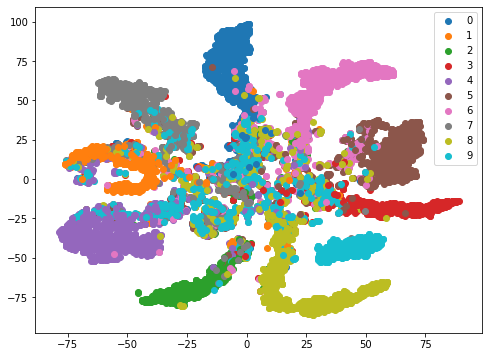

In [12]:
plt.figure(figsize=(8, 6))

for i in range(10):
    select_idxs = np.where(X_labels == i)[0]
    select_domain_idxs = np.where(X_domains[select_idxs] == 1)[0]
    plt.scatter(x=X_embed[select_idxs[select_domain_idxs], 0], y=X_embed[select_idxs[select_domain_idxs], 1], c='C{}'.format(i))
    
for i in range(10):
    select_idxs = np.where(X_labels == i)[0]
    select_domain_idxs = np.where(X_domains[select_idxs] == 0)[0]
    plt.scatter(x=X_embed[select_idxs[select_domain_idxs], 0], y=X_embed[select_idxs[select_domain_idxs], 1], c='C{}'.format(i), label=i)
    
plt.legend()

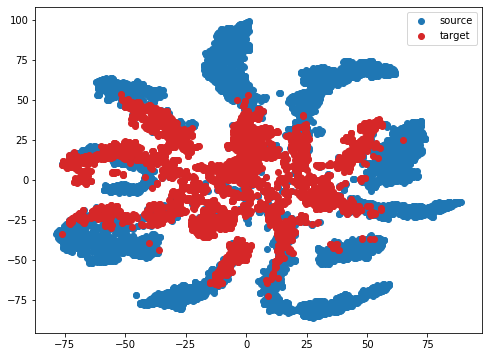

In [13]:
plt.figure(figsize=(8, 6))

for i in range(2):
    select_idxs = np.where(X_domains == i)[0]
    plt.scatter(x=X_embed[select_idxs, 0], y=X_embed[select_idxs, 1], c='C0' if i == 0 else 'C3', label='source' if i == 0 else 'target')
plt.legend()